In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten,Input
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
from keras.callbacks import ModelCheckpoint
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import seaborn as sns
sns.set_style('darkgrid')
from sklearn.metrics import confusion_matrix, classification_report
from IPython.display import display, HTML

### iterate through the folders to create a dataframe of the form filepaths labels

In [2]:
sdir=r'C:\Users\ASUS-ROG\PycharmProjects\MY-PY\Dataset'

filepaths=[]
labels=[]
classlist=os.listdir(sdir)
for klass in classlist:
    classpath=os.path.join(sdir,klass)
    if os.path.isdir(classpath):
        flist=os.listdir(classpath)
        for f in flist:
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(klass)                   
Fseries= pd.Series(filepaths, name='filepaths')
Lseries=pd.Series(labels, name='labels')    
df=pd.concat([Fseries, Lseries], axis=1)
print (df.head())
print (df['labels'].value_counts())

                                           filepaths              labels
0  C:\Users\ASUS-ROG\PycharmProjects\MY-PY\Datase...  Data Sawi Ada Hama
1  C:\Users\ASUS-ROG\PycharmProjects\MY-PY\Datase...  Data Sawi Ada Hama
2  C:\Users\ASUS-ROG\PycharmProjects\MY-PY\Datase...  Data Sawi Ada Hama
3  C:\Users\ASUS-ROG\PycharmProjects\MY-PY\Datase...  Data Sawi Ada Hama
4  C:\Users\ASUS-ROG\PycharmProjects\MY-PY\Datase...  Data Sawi Ada Hama
Data Sawi Tanpa Hama    500
Data Sawi Ada Hama      500
Name: labels, dtype: int64


### split df into train_df, test_df and valid_df

In [3]:
train_split=.8
test_split=.1
dummy_split=test_split/(1-train_split)
train_df, dummy_df=train_test_split(df, train_size=train_split, shuffle=True, random_state=123)
test_df, valid_df=train_test_split(dummy_df, train_size=dummy_split, shuffle=True, random_state=123)
print ('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))

train_df length:  800   test_df length:  100   valid_df length:  100


### create train, test, valid  generators

In [4]:
height=128
width=128
channels=3
batch_size=64

img_shape=(height, width, channels)
img_size=(height, width)
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
test_steps=int(length/test_batch_size)
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps)

gen=ImageDataGenerator(
    rescale=1./255,
    )
train_gen=gen.flow_from_dataframe( train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)

validgen=ImageDataGenerator(rescale=1./255)
valid_gen=validgen.flow_from_dataframe( valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)

testgen=ImageDataGenerator(rescale=1./255)
test_gen=testgen.flow_from_dataframe( test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=test_batch_size)

classes=list(train_gen.class_indices.keys())
print (classes)
class_count=len(classes)



test batch size:  50   test steps:  2
Found 799 validated image filenames belonging to 2 classes.
Found 100 validated image filenames belonging to 2 classes.
Found 100 validated image filenames belonging to 2 classes.
['Data Sawi Ada Hama', 'Data Sawi Tanpa Hama']


C:\Users\ASUS-ROG\anaconda3\lib\site-packages\keras\preprocessing\image.py:1139: UserWarning: Found 1 invalid image filename(s) in x_col="filepaths". These filename(s) will be ignored.
  warnings.warn(


### create function to show some image examples

In [5]:
def show_image_samples(gen):
    test_dict=test_gen.class_indices
    classes=list(test_dict.keys())    
    images,labels=next(gen) # get a sample batch from the generator 
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=images[i]
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
    plt.show()

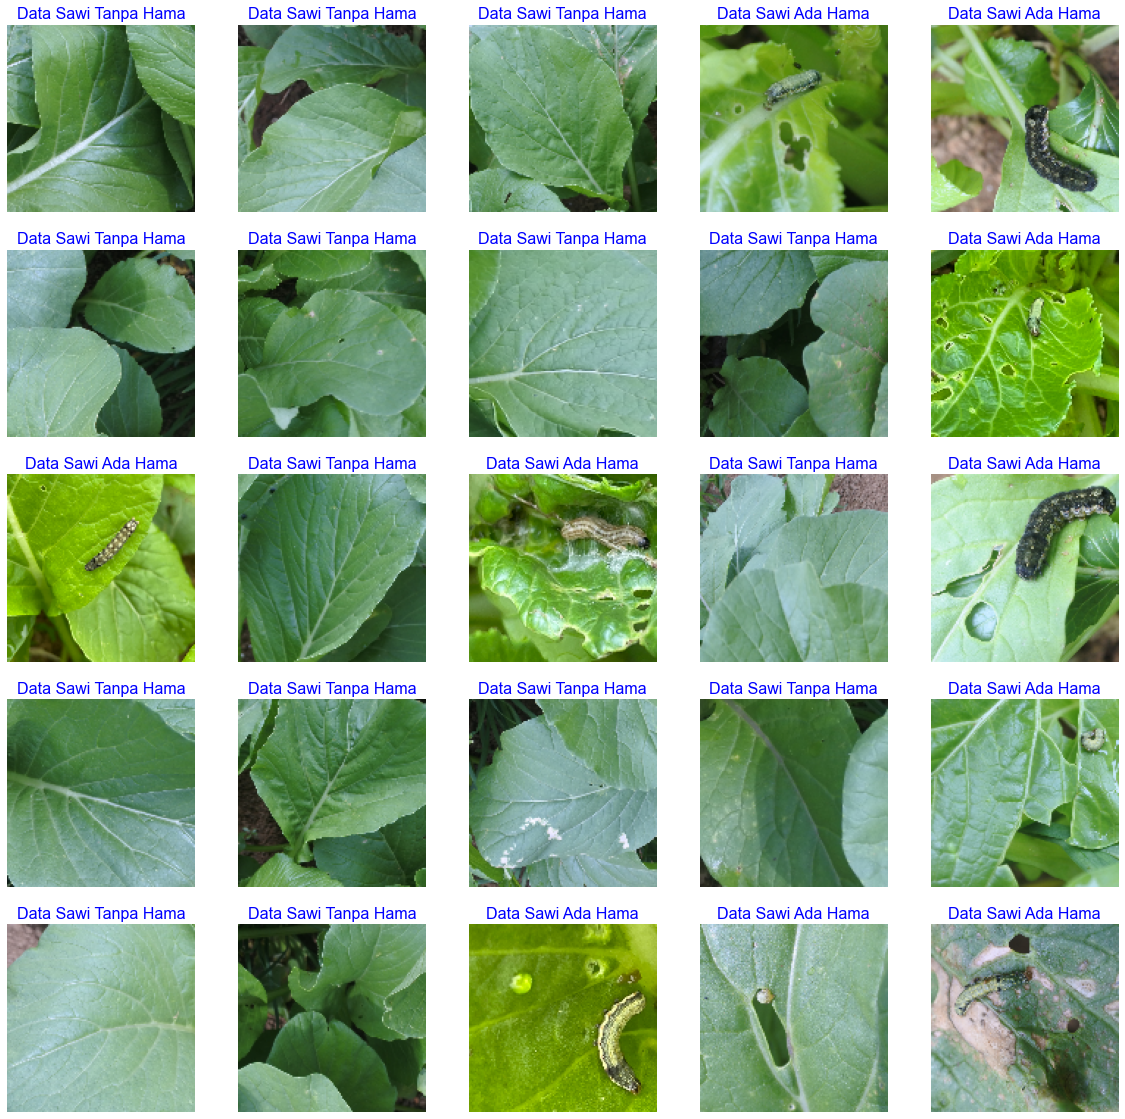

In [6]:
show_image_samples(train_gen)

### create the model

In [7]:
base_model=tf.keras.applications.NASNetMobile(include_top=False, weights="imagenet",input_tensor=Input(shape=(128,128,3))) 

In [8]:
base_model.summary()

Model: "NASNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv1 (Conv2D)            (None, 63, 63, 32)   864         ['input_1[0][0]']                
                                                                                                  
 stem_bn1 (BatchNormalization)  (None, 63, 63, 32)   128         ['stem_conv1[0][0]']             
                                                                                                  
 activation (Activation)        (None, 63, 63, 32)   0           ['stem_bn1[0][0]']          

 right2_stem_1 (BatchNormalizat                                  t2_stem_1[0][0]']                
 ion)                                                                                             
                                                                                                  
 separable_conv_1_reduction_rig  (None, 32, 32, 11)  1152        ['separable_conv_1_pad_reduction_
 ht3_stem_1 (SeparableConv2D)                                    right3_stem_1[0][0]']            
                                                                                                  
 separable_conv_1_reduction_lef  (None, 32, 32, 11)  220         ['activation_9[0][0]']           
 t4_stem_1 (SeparableConv2D)                                                                      
                                                                                                  
 activation_6 (Activation)      (None, 32, 32, 11)   0           ['separable_conv_1_bn_reduction_r
          

                                                                                                  
 reduction_concat_stem_1 (Conca  (None, 32, 32, 44)  0           ['reduction_add_2_stem_1[0][0]', 
 tenate)                                                          'reduction_add3_stem_1[0][0]',  
                                                                  'add[0][0]',                    
                                                                  'reduction_add4_stem_1[0][0]']  
                                                                                                  
 adjust_avg_pool_1_stem_2 (Aver  (None, 32, 32, 32)  0           ['adjust_relu_1_stem_2[0][0]']   
 agePooling2D)                                                                                    
                                                                                                  
 adjust_avg_pool_2_stem_2 (Aver  (None, 32, 32, 32)  0           ['cropping2d[0][0]']             
 agePoolin

 reduction_add_1_stem_2 (Add)   (None, 16, 16, 22)   0           ['separable_conv_2_bn_reduction_l
                                                                 eft1_stem_2[0][0]',              
                                                                  'separable_conv_2_bn_reduction_r
                                                                 ight1_stem_2[0][0]']             
                                                                                                  
 separable_conv_1_reduction_rig  (None, 16, 16, 22)  1562        ['separable_conv_1_pad_reduction_
 ht2_stem_2 (SeparableConv2D)                                    right2_stem_2[0][0]']            
                                                                                                  
 separable_conv_1_pad_reduction  (None, 35, 35, 22)  0           ['activation_18[0][0]']          
 _right3_stem_2 (ZeroPadding2D)                                                                   
          

 D)                                                                                               
                                                                                                  
 reduction_add3_stem_2 (Add)    (None, 16, 16, 22)   0           ['reduction_left3_stem_2[0][0]', 
                                                                  'separable_conv_2_bn_reduction_r
                                                                 ight3_stem_2[0][0]']             
                                                                                                  
 add_1 (Add)                    (None, 16, 16, 22)   0           ['reduction_add_2_stem_2[0][0]', 
                                                                  'reduction_left4_stem_2[0][0]'] 
                                                                                                  
 reduction_add4_stem_2 (Add)    (None, 16, 16, 22)   0           ['separable_conv_2_bn_reduction_l
          

 activation_24 (Activation)     (None, 16, 16, 44)   0           ['separable_conv_1_bn_normal_left
                                                                 1_0[0][0]']                      
                                                                                                  
 activation_26 (Activation)     (None, 16, 16, 44)   0           ['separable_conv_1_bn_normal_righ
                                                                 t1_0[0][0]']                     
                                                                                                  
 activation_28 (Activation)     (None, 16, 16, 44)   0           ['separable_conv_1_bn_normal_left
                                                                 2_0[0][0]']                      
                                                                                                  
 activation_30 (Activation)     (None, 16, 16, 44)   0           ['separable_conv_1_bn_normal_righ
          

 activation_34 (Activation)     (None, 16, 16, 264)  0           ['normal_concat_0[0][0]']        
                                                                                                  
 adjust_conv_projection_1 (Conv  (None, 16, 16, 44)  3872        ['activation_33[0][0]']          
 2D)                                                                                              
                                                                                                  
 normal_conv_1_1 (Conv2D)       (None, 16, 16, 44)   11616       ['activation_34[0][0]']          
                                                                                                  
 adjust_bn_1 (BatchNormalizatio  (None, 16, 16, 44)  176         ['adjust_conv_projection_1[0][0]'
 n)                                                              ]                                
                                                                                                  
 normal_bn

 separable_conv_2_bn_normal_lef  (None, 16, 16, 44)  176         ['separable_conv_2_normal_left1_1
 t1_1 (BatchNormalization)                                       [0][0]']                         
                                                                                                  
 separable_conv_2_bn_normal_rig  (None, 16, 16, 44)  176         ['separable_conv_2_normal_right1_
 ht1_1 (BatchNormalization)                                      1[0][0]']                        
                                                                                                  
 separable_conv_2_bn_normal_lef  (None, 16, 16, 44)  176         ['separable_conv_2_normal_left2_1
 t2_1 (BatchNormalization)                                       [0][0]']                         
                                                                                                  
 separable_conv_2_bn_normal_rig  (None, 16, 16, 44)  176         ['separable_conv_2_normal_right2_
 ht2_1 (Ba

 2 (SeparableConv2D)                                                                              
                                                                                                  
 separable_conv_1_normal_right2  (None, 16, 16, 44)  2332        ['activation_53[0][0]']          
 _2 (SeparableConv2D)                                                                             
                                                                                                  
 separable_conv_1_normal_left5_  (None, 16, 16, 44)  2332        ['activation_55[0][0]']          
 2 (SeparableConv2D)                                                                              
                                                                                                  
 separable_conv_1_bn_normal_lef  (None, 16, 16, 44)  176         ['separable_conv_1_normal_left1_2
 t1_2 (BatchNormalization)                                       [0][0]']                         
          

                                                                 2_2[0][0]',                      
                                                                  'separable_conv_2_bn_normal_righ
                                                                 t2_2[0][0]']                     
                                                                                                  
 normal_add_3_2 (Add)           (None, 16, 16, 44)   0           ['normal_left3_2[0][0]',         
                                                                  'adjust_bn_2[0][0]']            
                                                                                                  
 normal_add_4_2 (Add)           (None, 16, 16, 44)   0           ['normal_left4_2[0][0]',         
                                                                  'normal_right4_2[0][0]']        
                                                                                                  
 normal_ad

                                                                 2_3[0][0]']                      
                                                                                                  
 activation_66 (Activation)     (None, 16, 16, 44)   0           ['separable_conv_1_bn_normal_righ
                                                                 t2_3[0][0]']                     
                                                                                                  
 activation_68 (Activation)     (None, 16, 16, 44)   0           ['separable_conv_1_bn_normal_left
                                                                 5_3[0][0]']                      
                                                                                                  
 separable_conv_2_normal_left1_  (None, 16, 16, 44)  3036        ['activation_60[0][0]']          
 3 (SeparableConv2D)                                                                              
          

                                                                                                  
 reduction_bn_1_reduce_4 (Batch  (None, 16, 16, 88)  352         ['reduction_conv_1_reduce_4[0][0]
 Normalization)                                                  ']                               
                                                                                                  
 adjust_bn_reduce_4 (BatchNorma  (None, 16, 16, 88)  352         ['adjust_conv_projection_reduce_4
 lization)                                                       [0][0]']                         
                                                                                                  
 activation_71 (Activation)     (None, 16, 16, 88)   0           ['reduction_bn_1_reduce_4[0][0]']
                                                                                                  
 activation_73 (Activation)     (None, 16, 16, 88)   0           ['adjust_bn_reduce_4[0][0]']     
          

 separable_conv_1_reduction_lef  (None, 8, 8, 88)    8536        ['activation_79[0][0]']          
 t4_reduce_4 (SeparableConv2D)                                                                    
                                                                                                  
 activation_76 (Activation)     (None, 8, 8, 88)     0           ['separable_conv_1_bn_reduction_r
                                                                 ight2_reduce_4[0][0]']           
                                                                                                  
 separable_conv_1_bn_reduction_  (None, 8, 8, 88)    352         ['separable_conv_1_reduction_righ
 right3_reduce_4 (BatchNormaliz                                  t3_reduce_4[0][0]']              
 ation)                                                                                           
                                                                                                  
 separable

                                                                  'reduction_add4_reduce_4[0][0]']
                                                                                                  
 adjust_avg_pool_1_5 (AveragePo  (None, 8, 8, 264)   0           ['adjust_relu_1_5[0][0]']        
 oling2D)                                                                                         
                                                                                                  
 adjust_avg_pool_2_5 (AveragePo  (None, 8, 8, 264)   0           ['cropping2d_2[0][0]']           
 oling2D)                                                                                         
                                                                                                  
 adjust_conv_1_5 (Conv2D)       (None, 8, 8, 44)     11616       ['adjust_avg_pool_1_5[0][0]']    
                                                                                                  
 adjust_co

                                                                                                  
 separable_conv_2_normal_right1  (None, 8, 8, 88)    8536        ['activation_85[0][0]']          
 _5 (SeparableConv2D)                                                                             
                                                                                                  
 separable_conv_2_normal_left2_  (None, 8, 8, 88)    9944        ['activation_87[0][0]']          
 5 (SeparableConv2D)                                                                              
                                                                                                  
 separable_conv_2_normal_right2  (None, 8, 8, 88)    8536        ['activation_89[0][0]']          
 _5 (SeparableConv2D)                                                                             
                                                                                                  
 separable

                                                                                                  
 activation_98 (Activation)     (None, 8, 8, 88)     0           ['adjust_bn_6[0][0]']            
                                                                                                  
 activation_100 (Activation)    (None, 8, 8, 88)     0           ['adjust_bn_6[0][0]']            
                                                                                                  
 activation_102 (Activation)    (None, 8, 8, 88)     0           ['normal_bn_1_6[0][0]']          
                                                                                                  
 separable_conv_1_normal_left1_  (None, 8, 8, 88)    9944        ['activation_94[0][0]']          
 6 (SeparableConv2D)                                                                              
                                                                                                  
 separable

 2D)                                                                                              
                                                                                                  
 normal_right4_6 (AveragePoolin  (None, 8, 8, 88)    0           ['adjust_bn_6[0][0]']            
 g2D)                                                                                             
                                                                                                  
 separable_conv_2_bn_normal_lef  (None, 8, 8, 88)    352         ['separable_conv_2_normal_left5_6
 t5_6 (BatchNormalization)                                       [0][0]']                         
                                                                                                  
 normal_add_1_6 (Add)           (None, 8, 8, 88)     0           ['separable_conv_2_bn_normal_left
                                                                 1_6[0][0]',                      
          

                                                                                                  
 separable_conv_1_bn_normal_rig  (None, 8, 8, 88)    352         ['separable_conv_1_normal_right2_
 ht2_7 (BatchNormalization)                                      7[0][0]']                        
                                                                                                  
 separable_conv_1_bn_normal_lef  (None, 8, 8, 88)    352         ['separable_conv_1_normal_left5_7
 t5_7 (BatchNormalization)                                       [0][0]']                         
                                                                                                  
 activation_107 (Activation)    (None, 8, 8, 88)     0           ['separable_conv_1_bn_normal_left
                                                                 1_7[0][0]']                      
                                                                                                  
 activatio

                                                                  'normal_add_2_7[0][0]',         
                                                                  'normal_add_3_7[0][0]',         
                                                                  'normal_add_4_7[0][0]',         
                                                                  'normal_add_5_7[0][0]']         
                                                                                                  
 activation_116 (Activation)    (None, 8, 8, 528)    0           ['normal_concat_6[0][0]']        
                                                                                                  
 activation_117 (Activation)    (None, 8, 8, 528)    0           ['normal_concat_7[0][0]']        
                                                                                                  
 adjust_conv_projection_8 (Conv  (None, 8, 8, 88)    46464       ['activation_116[0][0]']         
 2D)      

                                                                                                  
 separable_conv_2_normal_right2  (None, 8, 8, 88)    8536        ['activation_125[0][0]']         
 _8 (SeparableConv2D)                                                                             
                                                                                                  
 separable_conv_2_normal_left5_  (None, 8, 8, 88)    8536        ['activation_127[0][0]']         
 8 (SeparableConv2D)                                                                              
                                                                                                  
 separable_conv_2_bn_normal_lef  (None, 8, 8, 88)    352         ['separable_conv_2_normal_left1_8
 t1_8 (BatchNormalization)                                       [0][0]']                         
                                                                                                  
 separable

 _right1_reduce_8 (ZeroPadding2                                                                   
 D)                                                                                               
                                                                                                  
 separable_conv_1_reduction_lef  (None, 4, 4, 176)   35376       ['separable_conv_1_pad_reduction_
 t1_reduce_8 (SeparableConv2D)                                   left1_reduce_8[0][0]']           
                                                                                                  
 separable_conv_1_reduction_rig  (None, 4, 4, 176)   39600       ['separable_conv_1_pad_reduction_
 ht1_reduce_8 (SeparableConv2D)                                  right1_reduce_8[0][0]']          
                                                                                                  
 separable_conv_1_bn_reduction_  (None, 4, 4, 176)   704         ['separable_conv_1_reduction_left
 left1_red

                                                                                                  
 separable_conv_2_reduction_rig  (None, 4, 4, 176)   39600       ['activation_135[0][0]']         
 ht2_reduce_8 (SeparableConv2D)                                                                   
                                                                                                  
 activation_137 (Activation)    (None, 4, 4, 176)    0           ['separable_conv_1_bn_reduction_r
                                                                 ight3_reduce_8[0][0]']           
                                                                                                  
 activation_139 (Activation)    (None, 4, 4, 176)    0           ['separable_conv_1_bn_reduction_l
                                                                 eft4_reduce_8[0][0]']            
                                                                                                  
 reduction

                                                                  'adjust_conv_2_9[0][0]']        
                                                                                                  
 normal_conv_1_9 (Conv2D)       (None, 4, 4, 176)    123904      ['activation_140[0][0]']         
                                                                                                  
 adjust_bn_9 (BatchNormalizatio  (None, 4, 4, 176)   704         ['concatenate_3[0][0]']          
 n)                                                                                               
                                                                                                  
 normal_bn_1_9 (BatchNormalizat  (None, 4, 4, 176)   704         ['normal_conv_1_9[0][0]']        
 ion)                                                                                             
                                                                                                  
 activatio

 separable_conv_2_bn_normal_rig  (None, 4, 4, 176)   704         ['separable_conv_2_normal_right1_
 ht1_9 (BatchNormalization)                                      9[0][0]']                        
                                                                                                  
 separable_conv_2_bn_normal_lef  (None, 4, 4, 176)   704         ['separable_conv_2_normal_left2_9
 t2_9 (BatchNormalization)                                       [0][0]']                         
                                                                                                  
 separable_conv_2_bn_normal_rig  (None, 4, 4, 176)   704         ['separable_conv_2_normal_right2_
 ht2_9 (BatchNormalization)                                      9[0][0]']                        
                                                                                                  
 normal_left3_9 (AveragePooling  (None, 4, 4, 176)   0           ['normal_bn_1_9[0][0]']          
 2D)      

 separable_conv_1_normal_right2  (None, 4, 4, 176)   32560       ['activation_159[0][0]']         
 _10 (SeparableConv2D)                                                                            
                                                                                                  
 separable_conv_1_normal_left5_  (None, 4, 4, 176)   32560       ['activation_161[0][0]']         
 10 (SeparableConv2D)                                                                             
                                                                                                  
 separable_conv_1_bn_normal_lef  (None, 4, 4, 176)   704         ['separable_conv_1_normal_left1_1
 t1_10 (BatchNormalization)                                      0[0][0]']                        
                                                                                                  
 separable_conv_1_bn_normal_rig  (None, 4, 4, 176)   704         ['separable_conv_1_normal_right1_
 ht1_10 (B

                                                                 t2_10[0][0]']                    
                                                                                                  
 normal_add_3_10 (Add)          (None, 4, 4, 176)    0           ['normal_left3_10[0][0]',        
                                                                  'adjust_bn_10[0][0]']           
                                                                                                  
 normal_add_4_10 (Add)          (None, 4, 4, 176)    0           ['normal_left4_10[0][0]',        
                                                                  'normal_right4_10[0][0]']       
                                                                                                  
 normal_add_5_10 (Add)          (None, 4, 4, 176)    0           ['separable_conv_2_bn_normal_left
                                                                 5_10[0][0]',                     
          

 activation_172 (Activation)    (None, 4, 4, 176)    0           ['separable_conv_1_bn_normal_righ
                                                                 t2_11[0][0]']                    
                                                                                                  
 activation_174 (Activation)    (None, 4, 4, 176)    0           ['separable_conv_1_bn_normal_left
                                                                 5_11[0][0]']                     
                                                                                                  
 separable_conv_2_normal_left1_  (None, 4, 4, 176)   35376       ['activation_166[0][0]']         
 11 (SeparableConv2D)                                                                             
                                                                                                  
 separable_conv_2_normal_right1  (None, 4, 4, 176)   32560       ['activation_168[0][0]']         
 _11 (Sepa

                                                                                                  
 normal_bn_1_12 (BatchNormaliza  (None, 4, 4, 176)   704         ['normal_conv_1_12[0][0]']       
 tion)                                                                                            
                                                                                                  
 activation_177 (Activation)    (None, 4, 4, 176)    0           ['normal_bn_1_12[0][0]']         
                                                                                                  
 activation_179 (Activation)    (None, 4, 4, 176)    0           ['adjust_bn_12[0][0]']           
                                                                                                  
 activation_181 (Activation)    (None, 4, 4, 176)    0           ['adjust_bn_12[0][0]']           
                                                                                                  
 activatio

 separable_conv_2_bn_normal_rig  (None, 4, 4, 176)   704         ['separable_conv_2_normal_right2_
 ht2_12 (BatchNormalization)                                     12[0][0]']                       
                                                                                                  
 normal_left3_12 (AveragePoolin  (None, 4, 4, 176)   0           ['normal_bn_1_12[0][0]']         
 g2D)                                                                                             
                                                                                                  
 normal_left4_12 (AveragePoolin  (None, 4, 4, 176)   0           ['adjust_bn_12[0][0]']           
 g2D)                                                                                             
                                                                                                  
 normal_right4_12 (AveragePooli  (None, 4, 4, 176)   0           ['adjust_bn_12[0][0]']           
 ng2D)    

In [9]:
base_model.trainable = False 

In [10]:
model_name='Cendekia'
print("Building model with", base_model)
model = tf.keras.Sequential([
            # Note the input shape is the desired size of the image 128x128 with 3 bytes color
            # This is the first convolution
            base_model,
            tf.keras.layers.Conv2D(filters=32, padding='same', kernel_size=3, activation='relu', strides=1),
            tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
            tf.keras.layers.Dropout(rate=0.5),

            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(2, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.001), loss='categorical_crossentropy', metrics='accuracy')

Building model with <keras.engine.functional.Functional object at 0x0000029BCF69F8E0>


In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 NASNet (Functional)         (None, 4, 4, 1056)        4269716   
                                                                 
 conv2d (Conv2D)             (None, 4, 4, 32)          304160    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 2, 2, 32)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 2, 2, 32)          0         
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 2)                 258       
                                                        

In [12]:
epochs =10

history=model.fit(x=train_gen, epochs=epochs, validation_data=valid_gen)

Epoch 1/10
13/13 [==============================] - 53s 2s/step - loss: 0.4350 - accuracy: 0.8323 - val_loss: 0.1203 - val_accuracy: 0.9400
Epoch 2/10
13/13 [==============================] - 11s 839ms/step - loss: 0.1468 - accuracy: 0.9449 - val_loss: 0.1162 - val_accuracy: 0.9500
Epoch 3/10
13/13 [==============================] - 11s 854ms/step - loss: 0.0863 - accuracy: 0.9737 - val_loss: 0.0710 - val_accuracy: 0.9800
Epoch 4/10
13/13 [==============================] - 11s 814ms/step - loss: 0.0522 - accuracy: 0.9837 - val_loss: 0.0520 - val_accuracy: 0.9900
Epoch 5/10
13/13 [==============================] - 10s 800ms/step - loss: 0.0507 - accuracy: 0.9812 - val_loss: 0.0459 - val_accuracy: 1.0000
Epoch 6/10
13/13 [==============================] - 11s 826ms/step - loss: 0.0301 - accuracy: 0.9912 - val_loss: 0.0689 - val_accuracy: 0.9600
Epoch 7/10
13/13 [==============================] - 11s 882ms/step - loss: 0.0248 - accuracy: 0.9912 - val_loss: 0.0475 - val_accuracy: 0.9800
Ep

### define function to print text in RGB foreground and background colors

In [13]:
def print_in_color(txt_msg,fore_tupple,back_tupple,):
    #prints the text_msg in the foreground color specified by fore_tupple with the background specified by back_tupple 
    #text_msg is the text, fore_tupple is foregroud color tupple (r,g,b), back_tupple is background tupple (r,g,b)
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m' 
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True) # returns default print color to back to black
    return

### define function to plot the training data

In [14]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    #plt.style.use('fivethirtyeight')
    plt.show()


### define function to generate the confusion matrix and classification report

In [15]:
def print_info( test_gen, preds, print_code, save_dir, subject ):
    class_dict=test_gen.class_indices
    labels= test_gen.labels
    file_names= test_gen.filenames 
    error_list=[]
    true_class=[]
    pred_class=[]
    prob_list=[]
    new_dict={}
    error_indices=[]
    y_pred=[]
    for key,value in class_dict.items():
        new_dict[value]=key             # dictionary {integer of class number: string of class name}
    # store new_dict as a text fine in the save_dir
    classes=list(new_dict.values())     # list of string of class names
    dict_as_text=str(new_dict)
    dict_name= subject + '-' +str(len(classes)) +'.txt'  
    dict_path=os.path.join(save_dir,dict_name)    
    with open(dict_path, 'w') as x_file:
        x_file.write(dict_as_text)    
    errors=0      
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)        
        true_index=labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)            
            errors=errors + 1
        y_pred.append(pred_index)    
    if print_code !=0:
        if errors>0:
            if print_code>errors:
                r=errors
            else:
                r=print_code           
            msg='{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class' , 'True Class', 'Probability')
            print_in_color(msg, (0,255,0),(55,65,80))
            for i in range(r):                
                split1=os.path.split(error_list[i])                
                split2=os.path.split(split1[0])                
                fname=split2[1] + '/' + split1[1]
                msg='{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(fname, pred_class[i],true_class[i], ' ', prob_list[i])
                print_in_color(msg, (255,255,255), (55,65,60))
                #print(error_list[i]  , pred_class[i], true_class[i], prob_list[i])               
        else:
            msg='With accuracy of 100 % there are no errors to print'
            print_in_color(msg, (0,255,0),(55,65,80))
    if errors>0:
        plot_bar=[]
        plot_class=[]
        for  key, value in new_dict.items():        
            count=error_indices.count(key) 
            if count!=0:
                plot_bar.append(count) # list containg how many times a class c had an error
                plot_class.append(value)   # stores the class 
        fig=plt.figure()
        fig.set_figheight(len(plot_class)/3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c=plot_class[i]
            x=plot_bar[i]
            plt.barh(c, x, )
            plt.title( ' Errors by Class on Test Set')
    y_true= np.array(labels)        
    y_pred=np.array(y_pred)
    if len(classes)<= 30:
        # create a confusion matrix 
        cm = confusion_matrix(y_true, y_pred )        
        length=len(classes)
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_width= int(length * .5)
            fig_height= int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(length)+.5, classes, rotation= 90)
        plt.yticks(np.arange(length)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes)
    print("Classification Report:\n----------------------\n", clr)

### evaluate model on the test set then save the model

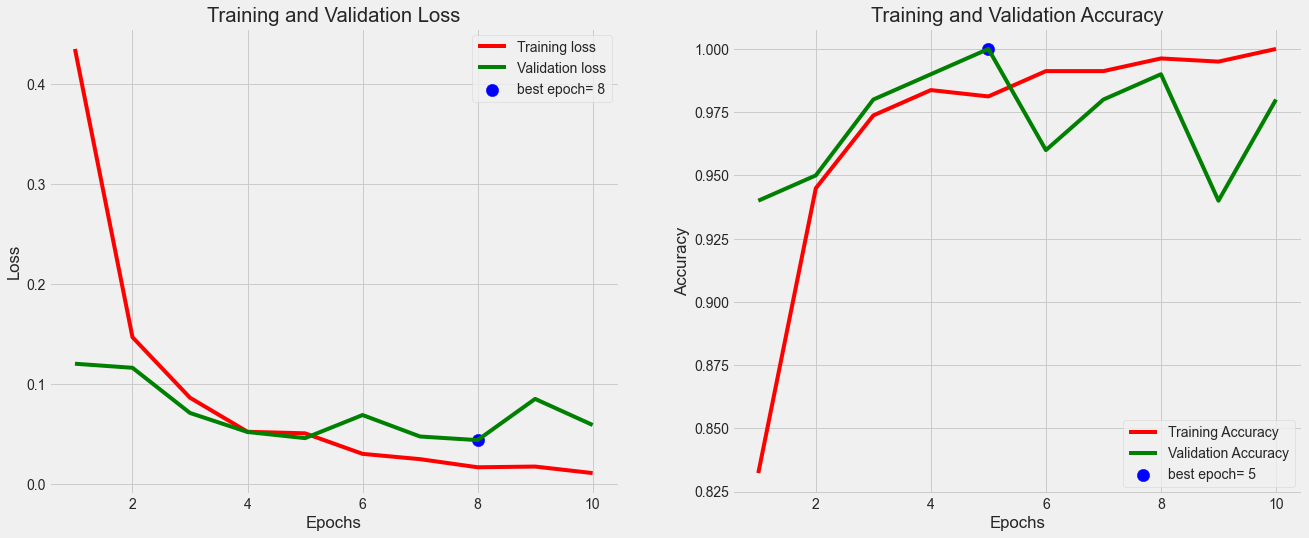

2/2 [==============================] - 1s 271ms/step - loss: 0.1165 - accuracy: 0.9600
accuracy on the test set is 96.00 %



In [16]:
tr_plot(history,0)
save_dir=r'./'
subject='pest'
acc=model.evaluate( test_gen, batch_size=test_batch_size, verbose=1, steps=test_steps, return_dict=False)[1]*100
msg=f'accuracy on the test set is {acc:5.2f} %'
print_in_color(msg, (0,255,0),(55,65,80))
save_id=str (model_name +  '-' + subject +'-'+ str(acc)[:str(acc).rfind('.')+3] + '.h5')
save_loc=os.path.join(save_dir, save_id)
model.save(save_loc)

### make predictions on test set and generate confusion matrix and classification report

2/2 [==============================] - 5s 517ms/step


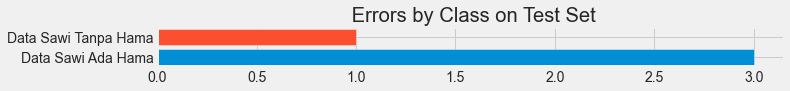

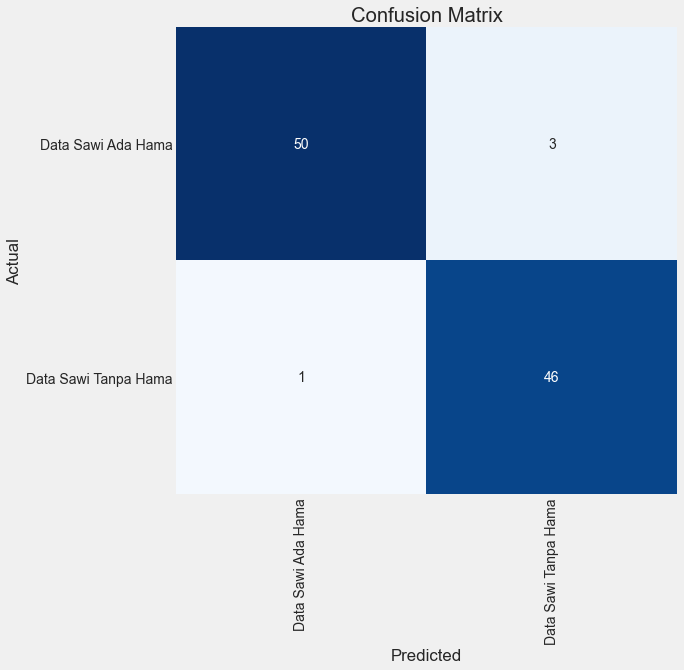

Classification Report:
----------------------
                       precision    recall  f1-score   support

  Data Sawi Ada Hama       0.98      0.94      0.96        53
Data Sawi Tanpa Hama       0.94      0.98      0.96        47

            accuracy                           0.96       100
           macro avg       0.96      0.96      0.96       100
        weighted avg       0.96      0.96      0.96       100



In [17]:
print_code=0
preds=model.predict(test_gen) 
print_info( test_gen, preds, print_code, save_dir, subject )  